<a href="https://colab.research.google.com/github/hau17/ptdl-python/blob/main/Social_Network_Analysis_Facebook_Combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Phân tích Mạng Xã hội Facebook

## 1. Tổng quan đề tài

### 1.1. Giới thiệu bài toán phân tích mạng xã

Mạng xã hội ngày càng đóng vai trò quan trọng trong cuộc sống hiện đại, cung cấp nền tảng để kết nối, trao đổi thông tin, và chia sẻ quan hệ xã hội giữa các cá nhân. Phân tích mạng xã hội giúp chúng ta hiểu rõ cấu trúc mạng, các nút trung tâm, mối quan hệ giữa các nhóm, và cách thông tin lan truyền trong mạng. Các ứng dụng phổ biến bao gồm phát hiện cộng đồng, dự đoán mối quan hệ mới, xác định người có ảnh hưởng, và nghiên cứu hành vi người dùng.

### 1.2. Giới thiệu dataset

Dataset SNAP Facebook Combined là tập dữ liệu mạng xã hội được thu thập từ Facebook, thuộc dự án Social Circles của Julian McAuley và Jure Leskovec (2012). Dataset đã được ẩn danh hóa các ID người dùng và các thuộc tính cá nhân để bảo vệ quyền riêng tư.

Số lượng mạng (egonets): 10

Số lượng nút (người dùng): 4,039

Số lượng cạnh (mối quan hệ bạn bè): 88,234

Số lượng vòng tròn (circles): 193

Dữ liệu được cung cấp ở dạng file text kết hợp (facebook_combined.txt), trong đó mỗi dòng biểu diễn một cạnh giữa hai người dùng u v (u và v là các ID người dùng). Dataset này phù hợp để phân tích mạng không hướng, đồng nhất, không trọng số.

### 1.3. Mục tiêu và phạm vi phân tích

Mục tiêu của bài phân tích:

* Khám phá cấu trúc tổng quan của mạng xã hội Facebook: số nút, số cạnh, đường kính, bán kính, hệ số phân cụm, phân phối bậc nút, độ dài đường đi trung bình.

* Phân tích các nút trung tâm dựa trên các chỉ số trung tâm (degree, closeness, betweenness, eigenvector, PageRank/HITS).

* Phát hiện cộng đồng, đánh giá chất lượng phân nhóm, và trực quan hóa mạng.

* Rút ra nhận định về cấu trúc mạng và các nút có vai trò quan trọng trong mạng xã hội.

Phạm vi phân tích:

* Sử dụng dataset combined từ SNAP Facebook.

* Phân tích mạng không hướng, không trọng số.



## 2. Phân tích tổng quan mạng

### 2.1. Khai báo thư viện

In [ ]:
!pip uninstall community
!pip install python-louvain

Found existing installation: community 1.0.0b1
Uninstalling community-1.0.0b1:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/community-1.0.0b1.dist-info/*
    /usr/local/lib/python3.12/dist-packages/community/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.12/dist-packages/community/community_louvain.py
    /usr/local/lib/python3.12/dist-packages/community/community_status.py
Proceed (Y/n)? y
  Successfully uninstalled community-1.0.0b1


In [ ]:
import kagglehub
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import community.community_louvain as community_louvain
import matplotlib.cm as cm
import seaborn as sns
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster
from networkx.algorithms import community

from networkx.algorithms.community import greedy_modularity_communities, label_propagation_communities
from networkx.algorithms.community.quality import modularity


### 2.2. Tải dữ liệu

In [ ]:


# 1. Tải dataset
path = kagglehub.dataset_download("pypiahmad/social-circles")

# File Facebook
data_file_name = "facebook_combined.txt"
data_file_path = os.path.join(path, data_file_name)

# 2. Đọc dữ liệu
df = pd.read_csv(data_file_path, sep=' ', header=None, names=["u", "v"])
print("--- Dữ liệu ban đầu ---")
print("5 dòng đầu:\n", df.head())
print(f"Kích thước ban đầu: {df.shape}\n")


100%|██████████| 825M/825M [00:41<00:00, 21.1MB/s]

Extracting files...


--- Dữ liệu ban đầu ---
5 dòng đầu:
    u  v
0  0  1
1  0  2
2  0  3
3  0  4
4  0  5
Kích thước ban đầu: (88234, 2)



### 2.3. Tiền xử lý dữ liệu

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88234 entries, 0 to 88233
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   u       88234 non-null  int64
 1   v       88234 non-null  int64
dtypes: int64(2)
memory usage: 1.3 MB


In [ ]:
# 3. XỬ LÝ DỮ LIỆU TRÙNG LẮP

# Kiểm tra dữ liệu trùng
duplicate_count = df.duplicated().sum()
print(f" Số lượng dòng bị trùng lặp: {duplicate_count}")

 Số lượng dòng bị trùng lặp: 0


In [ ]:
# 4. XỬ LÝ DỮ LIỆU BỊ THIẾU (MISSING VALUES)

# Kiểm tra dữ liệu thiếu
# isnull().sum() tính tổng theo cột, .sum() lần nữa để tính tổng toàn bộ dataframe
missing_count = df.isnull().sum().sum()
print(f" Số lượng ô dữ liệu bị thiếu (NaN/Null): {missing_count}")



 Số lượng ô dữ liệu bị thiếu (NaN/Null): 0


In [ ]:
# 5. TẠO ĐỒ THỊ (GRAPH)
G = nx.from_pandas_edgelist(df, "u", "v")



### 2.4. Kiểu đồ thị

Không hướng: quan hệ bạn bè là hai chiều.

Đồng nhất: tất cả nút là người dùng, tất cả cạnh là quan hệ bạn bè.

Không trọng số: mỗi cạnh chỉ biểu thị sự tồn tại mối quan hệ.

### 2.5. Thuộc tính nút/cạnh

Nút: ID người dùng. Không có thông tin cá nhân do dữ liệu đã được ẩn danh.

Cạnh: mối quan hệ bạn bè giữa hai người dùng. Không có trọng số hay hướng.

### 2.5. Số lượng nút và cạnh

In [ ]:
print("Số lượng nút (Nodes):", G.number_of_nodes())
print("Số lượng cạnh (Edges):", G.number_of_edges())

Số lượng nút (Nodes): 4039
Số lượng cạnh (Edges): 88234


### 2.6. Đường kính, bán kính

In [ ]:
# Lấy connected component lớn nhất
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc)
# tìm đường kính(khoảng cách xa nhất giữa 2 điểm bất kì trong đồ thị)
diameter = nx.diameter(G_lcc)
# tìm bán kính(vị trí trung tâm của đồ thị, giá trị Độ lệch tâm nhỏ nhất trong đồ thị)
radius = nx.radius(G_lcc)
print("Đường kính mạng:", diameter)
print("Bán kính mạng:", radius)


Đường kính mạng: 8
Bán kính mạng: 4


Nhận xét:
* Đường kính = 8

  * Đây là khoảng cách lớn nhất giữa hai người dùng bất kỳ trong thành phần liên thông lớn nhất của mạng.

  * Hai người xa nhau nhất chỉ cách nhau tối đa 8 bước kết nối, cho thấy khoảng cách toàn mạng khá nhỏ.

  * Điều này phản ánh đặc trưng small-world trong mạng xã hội: dù số lượng người nhiều và phân tán theo nhóm, nhưng vẫn có thể liên kết thông qua một số nút cầu nối.

* Bán kính = 4

  * Một số nút chỉ cần 4 bước kết nối để tiếp cận mọi người trong mạng.

  * Các nút này giữ vị trí “gần trung tâm”, có khả năng lan truyền thông tin nhanh và kết nối rộng.

Kết luận:
* Đường kính 8 và bán kính 4 cho thấy mạng có cấu trúc thế giới nhỏ: các cụm cộng đồng tồn tại nhưng vẫn liên thông hiệu quả. Đây là đặc trưng rất điển hình của mạng xã hội thật.

### 2.7. Hệ số phân cụm

Hệ số phân cụm toàn cục (Global Clustering Coefficient): 0.5191742775433075
Hệ số phân cụm trung bình cục bộ (Average Local Clustering): 0.6055467186200862


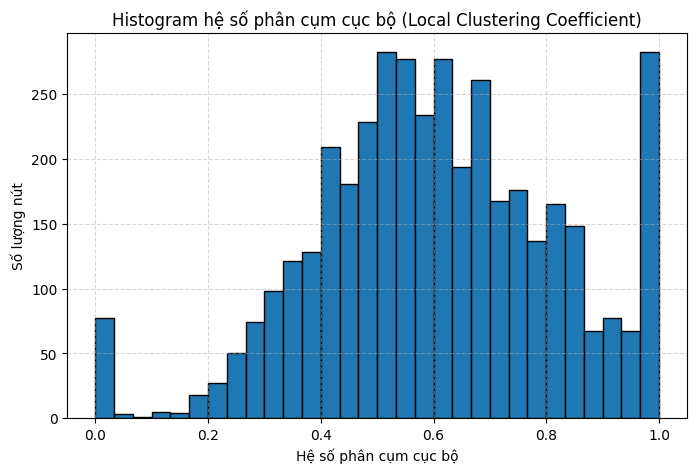

In [ ]:
# Global clustering coefficient (transitivity)
global_clustering = nx.transitivity(G)

# Local clustering coefficient for each node
local_clustering = nx.clustering(G)

# Average local clustering coefficient
avg_local_clustering = sum(local_clustering.values()) / len(local_clustering)

print("Hệ số phân cụm toàn cục (Global Clustering Coefficient):", global_clustering)
print("Hệ số phân cụm trung bình cục bộ (Average Local Clustering):", avg_local_clustering)

# Vẽ histogram hệ số phân cụm cục bộ

plt.figure(figsize=(8, 5))
plt.hist(local_clustering.values(), bins=30, edgecolor='black')
plt.title("Histogram hệ số phân cụm cục bộ (Local Clustering Coefficient)")
plt.xlabel("Hệ số phân cụm cục bộ")
plt.ylabel("Số lượng nút")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


Định nghĩa:

**Clustering Coefficient (Transitivity)**
Đo tỷ lệ các tam giác thực sự trên tổng số tam giác có thể tồn tại trong mạng. Nó phản ánh mức độ "tam giác hóa" của toàn bộ mạng.

Công thức tổng quát:

$$
C_{global} = \frac{3 \times \text{Số tam giác}}{\text{Số cặp cạnh có thể liên kết}}
$$

---

**Local Clustering Coefficient**
Đo mức độ liên kết giữa các hàng xóm của một nút. Cho biết hàng xóm của một nút có quen biết lẫn nhau hay không.

Công thức cho một nút $i$:

$$
C_i = \frac{\text{Số cạnh thực giữa các hàng xóm của } i}{\text{Số cạnh có thể tồn tại giữa các hàng xóm}}
$$

---

**Average Local Clustering**
Trung bình các hệ số clustering cục bộ của tất cả các nút, phản ánh mức độ gắn kết trung bình quanh từng cá nhân trong mạng:

$$
C_{avg} = \frac{1}{N} \sum_{i=1}^{N} C_i
$$




Nhận xét:

* Hệ số phân cụm toàn cục (Global Clustering Coefficient) = 0.519
→ Mạng có mức độ tam giác hóa khá cao. Các mối quan hệ thường không chỉ là kết nối đôi, mà còn khép thành vòng ba người (tam giác). Điều này phản ánh cấu trúc xã hội tự nhiên, nơi “bạn của bạn cũng thường là bạn của tôi”.

* Hệ số phân cụm trung bình cục bộ(Average Local Clustering) = 0.606
→ Trung bình, mỗi người dùng nằm trong một nhóm bạn bè tương đối gắn kết. Hàng xóm của một nút thường quen biết nhau, tạo ra các vòng tam giác dày đặc quanh từng cá nhân.

  → Hai chỉ số đều cho thấy mạng có tính cộng đồng mạnh.

* Histogram cho thấy phân phối hệ số phân cụm của các nút không dàn trải đều, mà:

  * Tập trung nhiều ở vùng 0.4 → 0.8, nghĩa là đa phần người dùng thuộc về những nhóm bạn bè khá kín, với mức độ kết nối chặt chẽ.

  * Giá trị clustering = 1.0 xuất hiện nhiều, cho thấy mạng có nhiều nhóm bạn hoàn toàn khép kín, nơi mọi người trong nhóm đều quen nhau.

  * Một lượng nhỏ nằm ở clustering = 0, tức là một số người có bạn bè không quen nhau; đây thường là các nút đóng vai trò cầu nối hoặc những người đứng ngoài cấu trúc cộng đồng.

Kết luận: Phân phối hệ số phân cụm cùng hai chỉ số tổng cho thấy đây là một mạng xã hội có cấu trúc cộng đồng rõ rệt, với nhiều nhóm bạn bè kín và mức độ tam giác hóa cao. Một số ít nút đóng vai trò liên kết xa, nhưng phần lớn người dùng thuộc về các vòng bạn bè chặt chẽ, phù hợp với đặc trưng xã hội thật.


### 2.8. Độ dài đường đi trung bình

In [ ]:
avg_path_length = nx.average_shortest_path_length(G_lcc)
print("Độ dài đường đi trung bình:", avg_path_length)


Độ dài đường đi trung bình: 3.6925068496963913


Độ dài đường đi trung bình = 3.6925

→ Trung bình, để đi từ một nút bất kỳ đến một nút khác trong connected component lớn nhất, cần khoảng 3.7 bước.

→ Điều này cho thấy mạng có khả năng kết nối khá tốt: dù đường kính là 8, nhưng hầu hết các cặp nút chỉ cách nhau dưới 4 bước.

### 2.9. Phân phối bậc

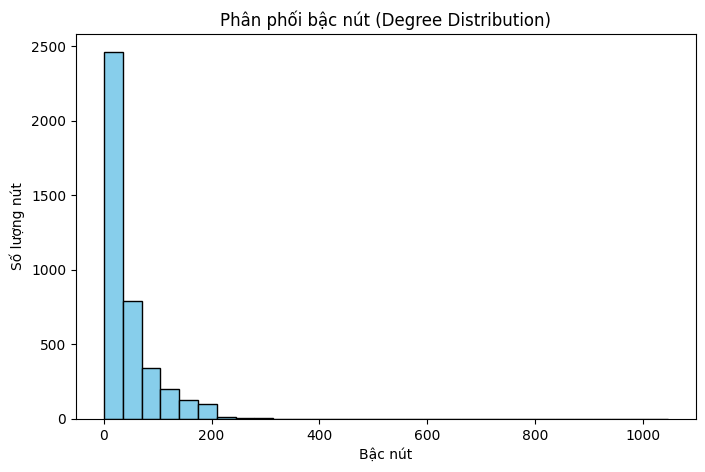

Hệ số góc (slope) của hồi quy log-log: -1.1801644192508824
Hệ số tương quan R^2: 0.8091782885710828


In [ ]:

# --- Lấy danh sách bậc nút ---
degrees = [d for n, d in G.degree()]

# Vẽ histogram phân phối bậc
plt.figure(figsize=(8,5))
plt.hist(degrees, bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Bậc nút")
plt.ylabel("Số lượng nút")
plt.title("Phân phối bậc nút (Degree Distribution)")
plt.show()

# Tính phân phối bậc (degree distribution)
degree_count = np.bincount(degrees)
k = np.arange(len(degree_count))
pk = degree_count / sum(degree_count)

# Loại bỏ các giá trị pk = 0 để tránh log(0)
k_nonzero = k[pk > 0]
pk_nonzero = pk[pk > 0]

#  Hồi quy log-log (linear regression)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(k_nonzero), np.log10(pk_nonzero))
print("Hệ số góc (slope) của hồi quy log-log:", slope)
print("Hệ số tương quan R^2:", r_value**2)


Định nghĩa:

* Bậc nút (Degree):

  * Là số lượng cạnh trực tiếp nối tới một nút trong mạng.

  * Ý nghĩa: đánh giá mức độ kết nối của một cá nhân trong mạng; nút có bậc cao thường là những hub, ảnh hưởng tới sự lan truyền thông tin hoặc kết nối cộng đồng.

* Power-law (Hồi quy log-log):

  * Định nghĩa: Mạng xã hội thường tuân theo Power-law: nhiều nút bậc thấp, rất ít nút bậc cao.

  * Hồi quy log-log: Lấy $\log_{10}$ của bậc nút $k$ và xác suất xuất hiện $p_k$, fit đường thẳng:$$
\log_{10}(p_k) = \text{slope} \cdot \log_{10}(k) + \text{intercept}
$$


  *  Hệ số góc (slope): Mức độ nghịch biến; slope âm → nút bậc cao hiếm, nút bậc thấp nhiều.

  * Hệ số tương quan $R^2$: Đo độ phù hợp của hồi quy log-log; giá trị gần 1 → dữ liệu tuân theo Power-law tốt.
  *  Ý nghĩa: Xác định mạng có tính scale-free, đặc trưng của nhiều mạng xã hội thực.

Nhận xét:

* Histogram phân phối bậc nút
  * Biểu đồ histogram cho thấy phần lớn nút trong mạng có bậc thấp (≤50), phản ánh rằng đa số người dùng sở hữu mạng bạn bè vừa phải, đúng với hành vi điển hình trong mạng xã hội.
Một số nút bậc trung bình (50–200) vẫn xuất hiện, đại diện cho những người dùng có khả năng kết nối vừa phải, có thể đóng vai trò cầu nối giữa các nhóm nhỏ.
  * Các nút bậc cao (>200), mặc dù số lượng rất ít, đại diện cho các hub, tức những người cực kỳ kết nối, đóng vai trò quan trọng trong việc rút ngắn khoảng cách trung bình và kết nối các cộng đồng khác nhau.

* Hồi quy log-log

  * Hệ số góc (slope) ≈ -1.18, giá trị âm biểu thị mối quan hệ nghịch biến giữa bậc nút và tần suất xuất hiện: các nút bậc cao rất hiếm, trong khi nút bậc thấp chiếm đa số.

  * Hệ số tương quan R² ≈ 0.81, chứng tỏ mối quan hệ log-log khá phù hợp với đường thẳng, xác nhận rằng phân phối bậc có thể mô hình hóa bằng power-law.

  * Điều này cho thấy mạng có tính scale-free, đặc trưng của các mạng xã hội thực: một số ít người dùng cực kỳ kết nối, trong khi đa phần người dùng có số lượng kết nối thấp.


Kết luận về cấu trúc mạng

* Mạng phi đồng đều về số lượng kết nối: nhiều nút bậc thấp, một số hub cực kỳ kết nối.

* Sự tồn tại của các hub giúp rút ngắn khoảng cách trung bình giữa các nút, kết hợp với đường kính nhỏ (8), bán kính trung tâm (4) và hệ số clustering cao (0.519 – 0.606), mạng thể hiện đặc trưng small-world.

* Cộng đồng rõ rệt nhưng vẫn được nối bởi các hub, đúng với cấu trúc mạng xã hội thật: nhóm bạn thân gắn kết nhưng vẫn có vài cá nhân kết nối rộng khắp mạng.

### 2.10. Bố cục mạng

/tmp/ipython-input-88496758.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_communities)


<Figure size 1200x1200 with 0 Axes>

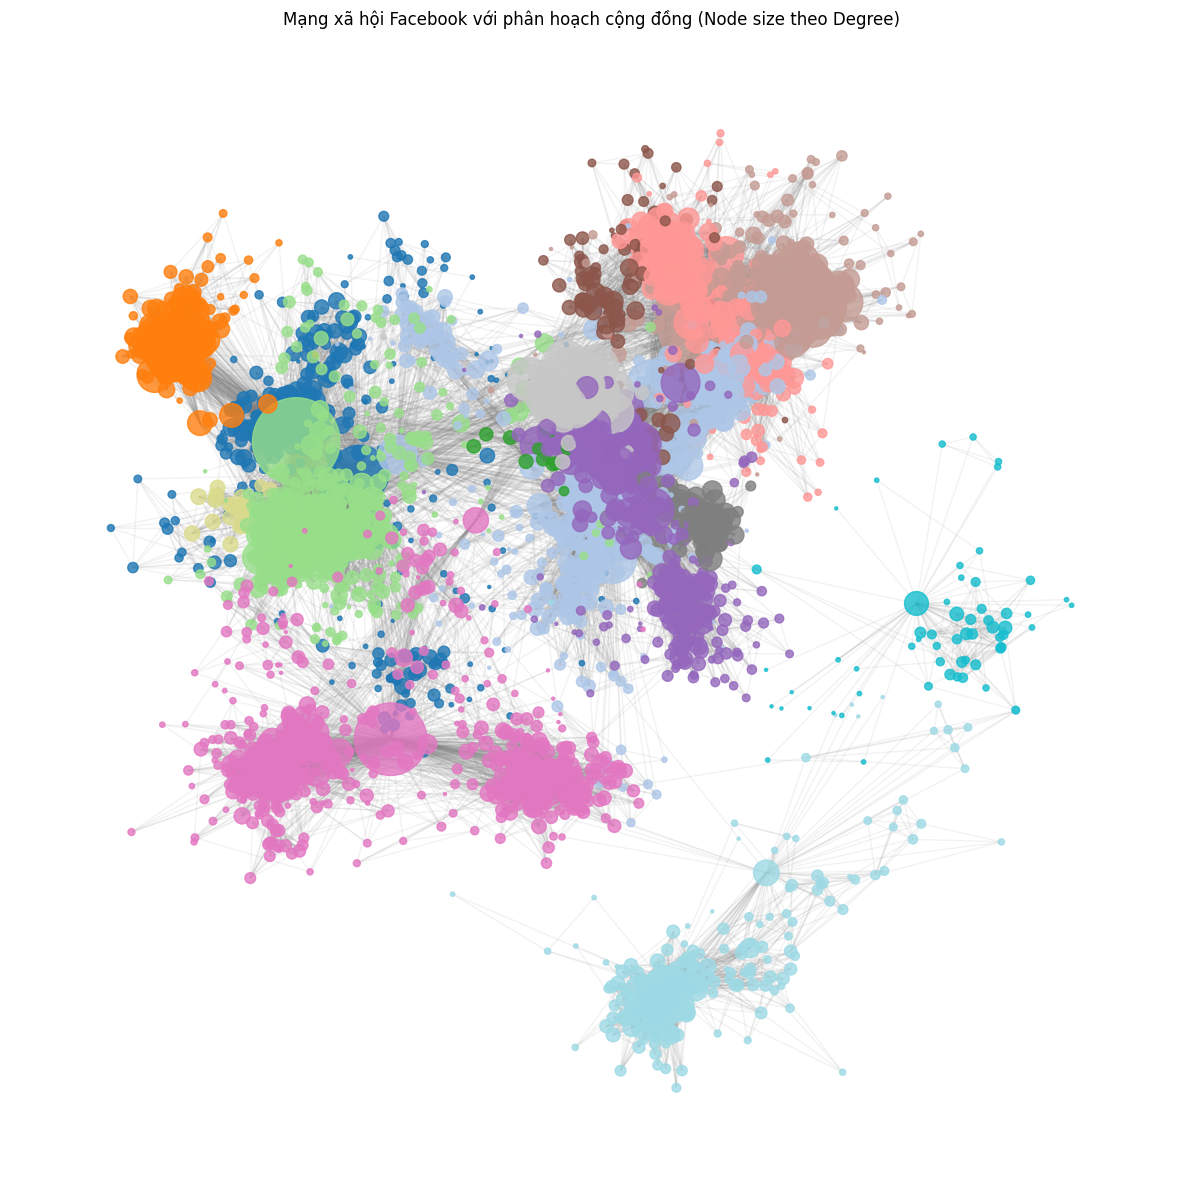

In [ ]:
# 1. Tìm cộng đồng bằng thuật toán Louvain
partition = community_louvain.best_partition(G)  # dict: node -> community

# 2. Tạo màu cho từng cộng đồng
num_communities = max(partition.values()) + 1
cmap = cm.get_cmap('tab20', num_communities)
node_colors = [cmap(partition[n]) for n in G.nodes()]

# 3. Kích cỡ nút theo degree(Số lượng kết nối trực tiếp mà một người có)
degrees = dict(G.degree())
node_sizes = [degrees[n]*2 for n in G.nodes()]  # nhân 2 cho trực quan hơn

# 4. Layout mạng
pos = nx.spring_layout(G, seed=42)  # Force-directed layout

# 5. Vẽ mạng
plt.figure(figsize=(12,12))
# Nhân với một hệ số (ví dụ: 10 hoặc 20) để nút to lên dễ nhìn
d = dict(G.degree)
node_sizes = [v * 5 for v in d.values()]  # Size tỷ lệ thuận với số bạn bè

# 3. Vẽ mạng
plt.figure(figsize=(15, 15)) # Tăng kích thước khung hình để đỡ rối
pos = nx.spring_layout(G, k=0.1, seed=42)  # tham số tỉ lệ k=0.2 giúp nới lỏng khoảng cách các nút

# Vẽ Nodes với kích thước động (node_sizes)
nx.draw_networkx_nodes(G, pos,
                       node_color=node_colors,
                       node_size=node_sizes, # <--- QUAN TRỌNG: Dùng size động
                       alpha=0.8) # Độ trong suốt

# Vẽ Edges (mỏng và mờ hơn để tôn vinh nodes)
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray')

plt.title("Mạng xã hội Facebook với phân hoạch cộng đồng (Node size theo Degree)")
plt.axis("off")
plt.show()
# nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
# nx.draw_networkx_edges(G, pos, alpha=0.2)
# plt.title("Bố cục mạng Facebook Combined")
# plt.axis('off')
# plt.show()


Nhận xét:
* Cấu trúc đa cực (Multi-polar network structure): Thuật toán Louvain cho thấy mạng được chia thành nhiều cộng đồng khác nhau (khoảng 5–7 nhóm), được mã hóa bằng các màu trong bảng tab20. Tuy nhiên, bố cục thực tế cho thấy các cụm không tách biệt hoàn toàn. Một số vùng màu xen kẽ và chồng lên nhau, phản ánh sự giao thoa tự nhiên giữa các nhóm xã hội (bạn học – đồng nghiệp – gia đình – nhóm sở thích).
Mạng vì vậy có dạng đa cực nhưng không phân mảnh cứng.

* Kích thước node thể hiện vai trò trung tâm. Node size tỉ lệ theo degree giúp lộ rõ các hub:

  * Mỗi cộng đồng đều có 1–2 node nổi bật với kích thước lớn hơn hẳn.

  * Các hub nằm ở trung tâm cụm màu, giữ vai trò kết nối chính và giúp mạng không tách thành nhiều thành phần rời rạc.

  * Một vài hub có kích thước vượt trội, biểu thị mức độ ảnh hưởng cao hơn trong cộng đồng của chúng.

* Sự liên kết và giao thoa giữa các cộng đồng

  * Quan sát edges cho thấy mạng không chia rời hoàn toàn:

  * Một số cụm ở trung tâm có nhiều kết nối giao nhau, làm màu các cộng đồng bị pha trộn.

  * Một số cụm ở rìa bố cục (thường như cụm xanh ngọc) có ít kết nối hơn và nằm cách xa hơn — gợi ý đây là một nhóm xã hội tách biệt hơn (ví dụ bạn ở tỉnh khác).

  * Hiện tượng “đè màu” phản ánh liên kết xã hội chồng lớp, đúng với đặc trưng của mạng xã hội người thật.

Kết luận:
Toàn mạng thể hiện các đặc điểm rõ rệt:

* Có cấu trúc theo cụm (clustered), dù ranh giới không cứng.

* Có cấu trúc cộng đồng mạnh(modularity), phù hợp với mô hình mạng xã hội thực.

* Có các hub phân cấp, với sự chênh lệch độ lớn node rõ rệt.

* Gần với đặc trưng scale-free, vì degree(Số lượng kết nối trực tiếp mà một người có) phân bố lệch: nhiều node nhỏ và vài node rất lớn.

## 3. Phân tích cấu trúc mạng

### 3.1. Phân tích các chỉ số trung tâm của mạng (Centrality Analysis)

In [ ]:
# --- CENTRALITY ANALYSIS ---

# Tính trung tâm theo bậc đỉnh(Degree Centrality):Đo số lượng kết nối trực tiếp mà một nút có.
deg_centrality = nx.degree_centrality(G)

# Tính trung tâm theo độ gần(Closeness Centrality):Đo khoảng cách trung bình từ một nút đến tất cả các nút khác trong mạng.
closeness = nx.closeness_centrality(G)

# Tính trung tâm theo khoảng cách( Betweenness Centrality):Đo mức độ mà một nút nằm trên các đường đi ngắn nhất giữa các nút khác.
betweenness = nx.betweenness_centrality(G, normalized=True)

# Tính trung tâm theo trị riêng(Eigenvector Centrality):Không chỉ đếm số kết nối, mà còn xem xét chất lượng các kết nối.
eigenvector = nx.eigenvector_centrality(G, max_iter=500)

# Tạo bảng top 10 nút quan trọng theo từng chỉ số

df_centrality = pd.DataFrame({
    "Degree": deg_centrality,
    "Closeness": closeness,
    "Betweenness": betweenness,
    "Eigenvector": eigenvector
})

# Sắp xếp theo từng tiêu chí
top_degree = df_centrality.sort_values("Degree", ascending=False).head(10)
top_closeness = df_centrality.sort_values("Closeness", ascending=False).head(10)
top_betweenness = df_centrality.sort_values("Betweenness", ascending=False).head(10)
top_eigen = df_centrality.sort_values("Eigenvector", ascending=False).head(10)

# In ra 4 bảng
print("Top 10 nút trung tâm theo bậc đỉnh")
print(top_degree, "\n")

print("Top 10 nút trung tâm theo độ gần")
print(top_closeness, "\n")

print("Top 10 nút trung tâm theo khoảng cách")
print(top_betweenness, "\n")

print("Top 10 nút trung tâm theo trị riêng")
print(top_eigen, "\n")


Top 10 nút trung tâm theo bậc đỉnh
        Degree  Closeness  Betweenness   Eigenvector
107   0.258791   0.459699     0.480518  2.606940e-04
1684  0.196137   0.393606     0.337797  7.164260e-06
1912  0.186974   0.350947     0.229295  9.540696e-02
3437  0.135463   0.314413     0.236115  9.531613e-08
0     0.085934   0.353343     0.146306  3.391796e-05
2543  0.072808   0.291300     0.007605  7.287131e-02
2347  0.072065   0.283408     0.003200  8.032160e-02
1888  0.062902   0.321292     0.000118  1.060441e-04
1800  0.060674   0.321599     0.000153  1.019310e-04
1663  0.058197   0.339185     0.001100  1.285378e-04 

Top 10 nút trung tâm theo độ gần
        Degree  Closeness  Betweenness  Eigenvector
107   0.258791   0.459699     0.480518     0.000261
58    0.002972   0.397402     0.084360     0.000590
428   0.028479   0.394837     0.064309     0.000599
563   0.022536   0.393913     0.062780     0.000601
1684  0.196137   0.393606     0.337797     0.000007
171   0.005448   0.370493     0.015

Định nghĩa các chỉ số

* Degree Centrality (Bậc đỉnh): Đếm số lượng liên kết trực tiếp mà một nút có. Node có degree cao thường là “hub” trong cộng đồng.

* Closeness Centrality (Độ gần): Đo khoảng cách trung bình từ một nút đến tất cả các nút khác. Node có closeness cao có khả năng lan truyền thông tin nhanh.

* Betweenness Centrality (Độ trung gian): Đo mức độ mà một node nằm trên đường đi ngắn nhất giữa các cặp nút. Node có betweenness cao là cầu nối quan trọng giữa các cộng đồng.

* Eigenvector Centrality (Trị riêng): Đo mức độ ảnh hưởng của một node dựa trên kết nối với các node quan trọng khác. Node có eigenvector cao có ảnh hưởng mạnh trong mạng.

Phân tích top 10 nút trung tâm theo từng chỉ số


* Degree Centrality:

  * Node 107 dẫn đầu, có nhiều kết nối trực tiếp, là hub chính trong mạng.

  * Node 1684, 1912, 3437 cũng có degree cao, chứng tỏ chúng là các nút trung tâm trong các cộng đồng riêng biệt.

  * Một số node khác (0, 2543, 2347…) có degree vừa phải nhưng vẫn nằm trong top 10, cho thấy mạng có hub mạnh và nhiều node trung gian vừa phải.

* Closeness Centrality:

  * Node 107 vẫn dẫn đầu, vừa kết nối nhiều vừa ở vị trí trung tâm mạng.

  * Node 58, 428, 563 có closeness cao nhưng degree thấp, nghĩa là chúng nằm gần trung tâm mạng nhưng ít kết nối trực tiếp, phù hợp với vai trò truyền thông tin nhanh trong mạng.

* Betweenness Centrality:

  * Node 107 và 1684 có betweenness cao, chứng tỏ là cầu nối quan trọng giữa các nhóm.

  * Node 3437 và 1912 cũng đóng vai trò trung gian, giữ liên kết giữa các cộng đồng, đảm bảo mạng không bị phân mảnh.

* Eigenvector Centrality:

  * Node 1912 đứng đầu, cho thấy node này kết nối với nhiều node quan trọng khác, có ảnh hưởng lan tỏa mạnh.

  * Các node còn lại trong top 10 eigenvector có giá trị khá gần nhau, thể hiện một nhóm các nút quan trọng về mức độ kết nối với các node “mạnh” khác trong mạng.
Nhận xét

* Các node đứng đầu theo degree thường cũng có closeness và betweenness cao, nhưng không nhất thiết có eigenvector cao (ví dụ Node 107).

* Eigenvector nhấn mạnh ảnh hưởng gián tiếp: node 1912 có eigenvector cao nhưng degree và betweenness không đứng đầu, cho thấy kết nối đến những node quyền lực khác là quan trọng.

* Betweenness chỉ ra vai trò cầu nối giữa các cộng đồng, node này không phải lúc nào cũng có degree cao.

* Closeness thể hiện khả năng truyền thông tin nhanh, một số node ít kết nối vẫn có closeness cao nếu nằm gần trung tâm mạng.

Kết luận

* Node trung tâm trong mạng xã hội có thể được xác định theo nhiều khía cạnh: degree, closeness, betweenness hoặc eigenvector.

* Một số node (ví dụ 107, 1912, 1684) xuất hiện trong nhiều top 10, đóng vai trò quan trọng trong cả việc kết nối trực tiếp, làm cầu nối giữa các cộng đồng và ảnh hưởng lan tỏa.

* Sự khác nhau giữa các chỉ số giúp hiểu mạng lưới đa chiều: một node có thể nổi bật về kết nối trực tiếp nhưng không phải là node trung gian quan trọng, hoặc ngược lại.


### 3.2. Tương quan giữa các chỉ số trung tâm

Ma trận tương quan giữa các độ đo trung tâm:
               Degree  Closeness  Betweenness  Eigenvector
Degree       1.000000   0.274716     0.451520     0.573532
Closeness    0.274716   1.000000     0.137091    -0.078656
Betweenness  0.451520   0.137091     1.000000     0.019522
Eigenvector  0.573532  -0.078656     0.019522     1.000000


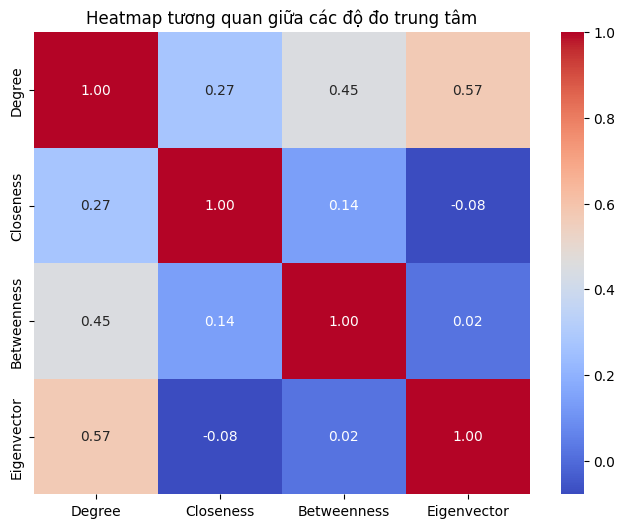

In [ ]:

# đã có df_centrality chứa các cột: Degree, Closeness, Betweenness, Eigenvector

# Tính ma trận tương quan Pearson
corr_matrix = df_centrality.corr(method='pearson')
print("Ma trận tương quan giữa các độ đo trung tâm:")
print(corr_matrix)

# Vẽ heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap tương quan giữa các độ đo trung tâm")
plt.show()


Nhận xét: dưới đây là các chỉ số

* Degree – Eigenvector (0.574)


  * Đây là mối tương quan dương khá cao.


  * Ý nghĩa: các nút hub (nhiều kết nối trực tiếp) thường kết nối với các nút quan trọng khác, do đó có ảnh hưởng lan tỏa mạnh trong mạng.Đây là chỉ số quan trọng, phản ánh các nút trung tâm về kết nối và sức ảnh hưởng.




* Degree – Betweenness (0.452)


  * Tương quan dương trung bình.


  * Ý nghĩa: các nút có nhiều kết nối cũng thường đóng vai trò cầu nối giữa các nhóm, nhưng không hoàn toàn. Một số cầu nối quan trọng có thể có bậc thấp. Đây là thông tin hữu ích để xác định các nút giữ liên kết mạng.




* Degree – Closeness (0.275)


  * Tương quan dương yếu.


  * Ý nghĩa: các hub đôi khi gần trung tâm mạng, nhưng nhiều hub vẫn có thể nằm ở ngoại vi. Chỉ số này chỉ có giá trị tham khảo, không quá quyết định.




Kết luận

* Trong mạng này, Degree và Eigenvector là hai chỉ số trung tâm quan trọng nhất, phản ánh cả số lượng kết nối và ảnh hưởng lan tỏa.


* Betweenness bổ sung thông tin về các nút cầu nối, giúp nhận diện những nút quan trọng trong việc kết nối các cộng đồng.


* Closeness ít ảnh hưởng trong việc xác định các nút “mạnh” hay “trung tâm” trong mạng này.


* Nhìn chung, các độ đo trung tâm phản ánh các khía cạnh khác nhau về vai trò và vị trí của nút, nên cần kết hợp để phân tích toàn diện.



### 3.3. Phân tích tính tương đương/tương tự về cấu trúc nút

Nút 2019 và 2033 có sự tương tự cấu trúc cao: 1.000
Nút 293 và 112 có sự tương tự cấu trúc cao: 1.000
Nút 253 và 97 có sự tương tự cấu trúc cao: 1.000
Nút 3927 và 3665 có sự tương tự cấu trúc cao: 1.000
Nút 2033 và 2019 có sự tương tự cấu trúc cao: 1.000


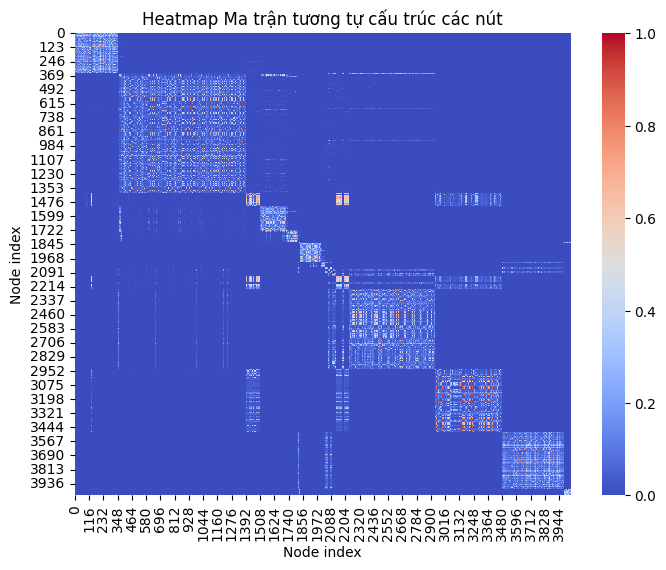

In [ ]:

# Tạo ma trận kề (adjacency matrix)
A = nx.to_numpy_array(G)

# Tính cosine similarity giữa các nút
sim_matrix = cosine_similarity(A)

np.fill_diagonal(sim_matrix, 0)

# Lấy indices của top 5 giá trị lớn nhất trong ma trận
top_n = 5
flat_indices = np.argpartition(sim_matrix.flatten(), -top_n)[-top_n:]
top_indices = np.array(np.unravel_index(flat_indices, sim_matrix.shape)).T

# In ra kết quả
for idx in top_indices:
    i, j = idx
    print(f"Nút {i} và {j} có sự tương tự cấu trúc cao: {sim_matrix[i,j]:.3f}")

#Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix, cmap="coolwarm", cbar=True)
plt.title("Heatmap Ma trận tương tự cấu trúc các nút")
plt.xlabel("Node index")
plt.ylabel("Node index")
plt.show()



Định nghĩa

* Cosine similarity: đo độ giống nhau giữa hai vector — dựa trên góc giữa chúng, không dựa trên độ lớn.

Công thức giữa hai vector $x$ và $y$:

$$
\text{cosine}(x,y)\;=\;\frac{x \cdot y}{\|x\|\|y\|}
$$

Giá trị nằm trong khoảng:

- $1$ → hoàn toàn giống nhau (cùng hướng)  
- $0$ → không liên quan (vuông góc)  
- $-1$ → đối ngược (rất hiếm trong ma trận kề)



Nhận xét

* Thông qua biểu đồ heapmap, ta thấy được:

  * Tồn tại 1 vài nút có sự tương tự cấu trúc cao( 2019 và 2033,
 293 và 112, ...). Điều này cho thấy hai nút này có các mối quan hệ gần như giống hệt nhau, nghĩa là chúng nằm trong cùng một “mẫu kết nối” trong mạng, có vai trò cấu trúc tương đương.

* Đặc điểm mạng:

  * Một số nút có độ tương tự rất cao, cho thấy mạng có nhiều cặp nút đóng vai trò tương đương.

  * Có thể tồn tại các nhóm nút đồng nhất về cấu trúc, kết nối với cùng một tập các nút khác.

* Đa dạng cấu trúc:

  * Trong khi một số nút giống nhau hoàn toàn, các nút khác có độ tương tự thấp hơn. Điều này phản ánh sự đa dạng về vai trò và vị trí trong mạng, với một số hub nổi bật và nhiều nút có kết nối hạn chế.

Kết luận

* Mạng xã hội này có tính tương đương cấu trúc rõ rệt: một số nút đóng vai trò tương tự về mô hình kết nối, tạo nên các cặp hoặc nhóm nút đồng nhất.

* Phân tích tương tự cấu trúc giúp:

  * Xác định các nút thay thế được về mặt vai trò trong mạng.

  * Nhận diện các tiểu cộng đồng hoặc cluster cấu trúc, phục vụ cho việc phân tích nhóm, phát hiện vai trò nút, hoặc tối ưu hóa các chiến lược kết nối trong mạng.

* Kết hợp với các chỉ số trung tâm, thông tin này bổ sung chiều sâu về cấu trúc, không chỉ dựa trên số lượng kết nối hay khoảng cách, mà còn dựa trên mô hình kết nối xung quanh từng nút.

## 4. Phân tích cộng đồng trong mạng

### 4.1. Phát hiện cộng đồng

Core number của một số nút:
Node 0: k-core = 21
Node 1: k-core = 13
Node 2: k-core = 9
Node 3: k-core = 13
Node 4: k-core = 9
Node 5: k-core = 10
Node 6: k-core = 5
Node 7: k-core = 12
Node 8: k-core = 5
Node 9: k-core = 21
Số lượng nút theo từng giá trị k-core:
kcore
1       75
2      108
3      102
4      120
5      134
      ... 
111      4
112      3
113      2
114      7
115    158
Name: count, Length: 96, dtype: int64

K-core có số lượng nút lớn nhất: 70
Số lượng nút trong k-core này: 265

K-core cao nhất của mạng: 115
Số nút trong 115-core: 158
Số cạnh trong 115-core: 11144


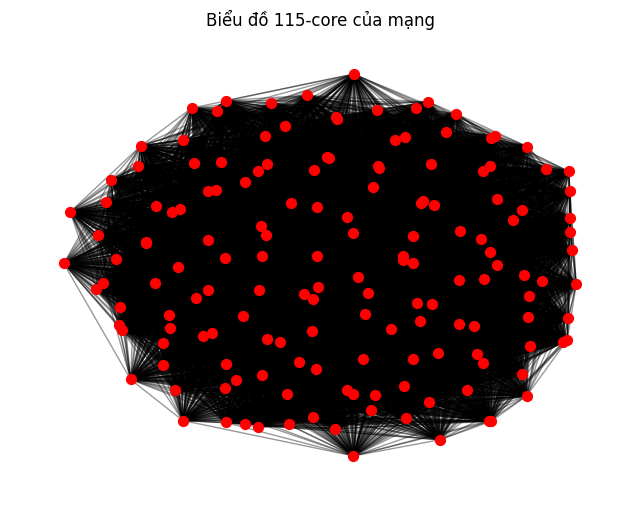

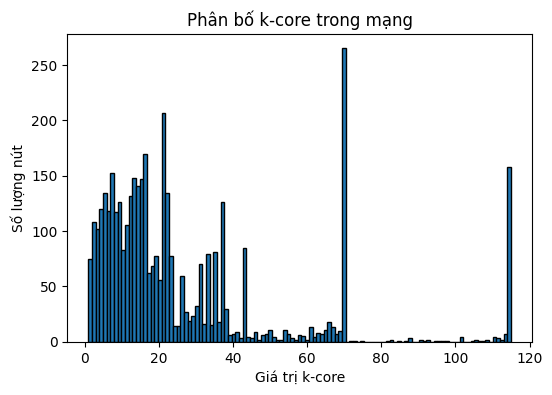

In [ ]:
# k-core decomposition
# 1. Tính core number cho từng nút
core_numbers = nx.core_number(G)



# In 10 nút đầu làm ví dụ
print("Core number của một số nút:")
for node in list(core_numbers)[:10]:
    print(f"Node {node}: k-core = {core_numbers[node]}")

df_core = pd.DataFrame.from_dict(core_numbers, orient="index", columns=["kcore"])

# Đếm số lượng nút theo từng k-core
core_count = df_core["kcore"].value_counts().sort_index()

print("Số lượng nút theo từng giá trị k-core:")
print(core_count)

# Tìm k-core có số lượng nút lớn nhất
max_kcore = core_count.idxmax()
max_count = core_count.max()

print(f"\nK-core có số lượng nút lớn nhất: {max_kcore}")
print(f"Số lượng nút trong k-core này: {max_count}")



# 2. Tìm k-core lớn nhất trong mạng
max_k = max(core_numbers.values())
print(f"\nK-core cao nhất của mạng: {max_k}")

# 3. Trích xuất subgraph k-core lớn nhất
core_subgraph = nx.k_core(G, k=max_k)

print(f"Số nút trong {max_k}-core: {core_subgraph.number_of_nodes()}")
print(f"Số cạnh trong {max_k}-core: {core_subgraph.number_of_edges()}")

# 4. Vẽ mạng k-core để trực quan
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(core_subgraph, seed=42)

nx.draw_networkx_nodes(core_subgraph, pos, node_size=50, node_color="red")
nx.draw_networkx_edges(core_subgraph, pos, alpha=0.4)

plt.title(f"Biểu đồ {max_k}-core của mạng")
plt.axis("off")
plt.show()

# 5. Vẽ phân bố core-number toàn mạng
plt.figure(figsize=(6, 4))
plt.hist(list(core_numbers.values()), bins=max_k, edgecolor="black")
plt.xlabel("Giá trị k-core")
plt.ylabel("Số lượng nút")
plt.title("Phân bố k-core trong mạng")
plt.show()


Định nghĩa:
* Một k-core là tập các nút trong mạng mà mỗi nút trong tập đều có bậc ≥ k, sau khi đã loại bỏ các nút yếu hơn.
* “k-core decomposition là một phương pháp phát hiện nhóm trong mạng bằng cách tìm ra các tập nút có mức độ kết nối tối thiểu k. Đây là kỹ thuật phổ biến để mô hình hóa cấu trúc nhóm và phân tích các tập lõi trong đồ thị. Trong bài này, phương pháp đã được áp dụng thông qua việc tính core-number và trích xuất k-core lớn nhất từ mạng.”

Nhận xét
* Phân bố k-core

  * Phần lớn các nút thuộc về các k-core thấp (từ 0 đến 40). Điều này cho thấy đa số người dùng trong mạng có mức độ kết nối trung bình hoặc thấp, đặc trưng của các mạng xã hội tự nhiên với rất nhiều nút có ít liên kết.

  * Số lượng nút cao nhất xuất hiện ở k-core = 70, với hơn 250 nút. Đây là nhóm có số lượng nút lớn nhất trong phân bố k-core, đóng vai trò như “lõi trung gian” của mạng, nơi các nút có mức kết nối đủ mạnh để tạo thành một vùng gắn kết nhưng chưa phải mức độ cao nhất.

* Nhóm k-core cao nhất (115-core)

  * Giá trị k-core tối đa là 115, với 158 nút.

  * Nhóm này tạo thành phần lõi mạnh nhất của mạng, nơi mỗi nút có ít nhất 115 liên kết nội bộ.

  * Với 11.144 cạnh nội bộ, 115-core thể hiện mức liên kết cực kỳ dày đặc, phản ánh một cộng đồng rất chặt chẽ, nhiều khả năng là nhóm bạn bè có quan hệ mạnh hoặc các cụm cộng đồng lớn trong Facebook.

* Đặc điểm cấu trúc mạng

  * Phân bố k-core trải rộng, cho thấy mạng có cấu trúc nhiều lớp, từ lớp ngoại vi (k thấp) đến vùng trung tâm (k cao).

  * Việc tồn tại một 115-core với 158 nút là dấu hiệu của một mạng quy mô lớn, gắn kết mạnh, có cấu trúc lõi rất đậm đặc.

  * Sự tập trung số lượng lớn nút ở k = 70 phản ánh một “vùng trung tâm mở rộng”, đóng vai trò cầu nối giữa các lớp thấp và lõi cao nhất.

Kết luận

* Mạng xã hội này có cấu trúc đa tầng, trong đó phần lớn các nút có mức độ liên kết thấp đến trung bình, còn các nút có mức kết nối cao hơn tập trung dần về lõi.

* Lõi của mạng (115-core) thể hiện một cộng đồng có tính kết nối rất mạnh, đóng vai trò nền tảng duy trì độ bền và tính liên kết tổng thể của mạng.

* Phân tích k-core cho thấy sự tồn tại của một cấu trúc lõi–vỏ (core–periphery structure) điển hình:

  * Lớp vỏ ngoài nhiều nhưng kết nối yếu

  * Lớp trung gian đông và kết nối khá mạnh

  * Lõi trung tâm nhỏ nhưng liên kết cực kỳ dày đặc

* Đây là đặc điểm phù hợp với các mạng xã hội thực tế, nơi một số nhóm người dùng cốt lõi đóng vai trò kết nối và duy trì sự lan truyền thông tin trong toàn mạng.

### 4.2. So sánh thuật toán phát hiện cộng đồng

In [ ]:

# -----------------------------
# 1. GREEDY MODULARITY
# -----------------------------
greedy_comm = list(greedy_modularity_communities(G))
greedy_mod = modularity(G, greedy_comm)

print("GREEDY MODULARITY")
print("Số cộng đồng:", len(greedy_comm))
print("Modularity:", round(greedy_mod, 4))
print()

# -----------------------------
# 2. LABEL PROPAGATION (LPA)
# -----------------------------
lpa_comm = list(label_propagation_communities(G))
lpa_mod = modularity(G, lpa_comm)

print("LABEL PROPAGATION (LPA)")
print("Số cộng đồng:", len(lpa_comm))
print("Modularity:", round(lpa_mod, 4))
print()

# -----------------------------
# 3. LOUVAIN
# -----------------------------
louvain_partition = community_louvain.best_partition(G)

# Chuyển dict -> list communities
from collections import defaultdict
comm_dict = defaultdict(list)
for node, comm_id in louvain_partition.items():
    comm_dict[comm_id].append(node)

louvain_comm = list(comm_dict.values())
louvain_mod = modularity(G, louvain_comm)

print("LOUVAIN METHOD")
print("Số cộng đồng:", len(louvain_comm))
print("Modularity:", round(louvain_mod, 4))
print()

# -----------------------------
# 4. BẢNG SO SÁNH
# -----------------------------
print("=== SO SÁNH CUỐI CÙNG ===")
print(f"Greedy Modularity → Communities: {len(greedy_comm)}, Modularity = {greedy_mod:.4f}")
print(f"LPA               → Communities: {len(lpa_comm)}, Modularity = {lpa_mod:.4f}")
print(f"Louvain           → Communities: {len(louvain_comm)}, Modularity = {louvain_mod:.4f}")


GREEDY MODULARITY
Số cộng đồng: 13
Modularity: 0.7774

LABEL PROPAGATION (LPA)
Số cộng đồng: 44
Modularity: 0.7368

LOUVAIN METHOD
Số cộng đồng: 14
Modularity: 0.8349

=== SO SÁNH CUỐI CÙNG ===
Greedy Modularity → Communities: 13, Modularity = 0.7774
LPA               → Communities: 44, Modularity = 0.7368
Louvain           → Communities: 14, Modularity = 0.8349


Định nghĩa:

Các thuật toán phát hiện cộng đồng giúp phân chia mạng thành các nhóm nút có liên kết chặt chẽ hơn bên trong so với bên ngoài. Dưới đây là một số phương pháp phổ biến:

1. Greedy Modularity (Clauset–Newman–Moore)
Thuật toán gộp các cộng đồng theo chiến lược tham lam nhằm tối đa hóa modularity Q. Ban đầu mỗi nút là một cộng đồng và từng bước gộp hai cộng đồng mang lại mức tăng modularity lớn nhất cho đến khi không thể cải thiện thêm. Phù hợp cho mạng vừa và lớn nhưng có thể rơi vào nghiệm cục bộ.

2. Label Propagation (LPA)
Thuật toán lan truyền nhãn không tham số. Mỗi nút bắt đầu với một nhãn riêng và liên tục cập nhật theo nhãn phổ biến nhất từ hàng xóm cho đến khi hội tụ. Rất nhanh và không cần biết trước số cộng đồng, nhưng kết quả có thể thay đổi giữa các lần chạy.

3. Louvain Method
Phương pháp tối ưu hóa modularity theo hai pha lặp lại: (1) di chuyển nút sang cộng đồng lân cận nếu modularity tăng, (2) gom mỗi cộng đồng thành siêu nút để tạo mạng mới và lặp lại. Cho kết quả modularity cao và xử lý tốt mạng lớn, dù có thể không hoàn toàn ổn định.

Nhận xét:

* So sánh và nhận xét theo số lượng cộng đồng

| Thuật toán            | Số cộng đồng | Nhận xét                                                      |
| --------------------- | ------------ | ------------------------------------------------------------- |
| **Greedy Modularity** | 13           | Tạo ra số lượng cộng đồng vừa phải, tương đối lớn và rõ ràng. |
| **LPA**               | 44           | Số cộng đồng nhiều nhất, tạo phân mảnh mạnh, dễ bị nhiễu.     |
| **Louvain**           | 14           | Gần giống Greedy nhưng ranh giới cụ thể và ổn định hơn.       |

LPA chia mạng thành rất nhiều cụm nhỏ → phù hợp khi mạng có nhiều cấu trúc vi mô nhưng không chính xác nếu cần cộng đồng lớn, rõ hình dạng.
Greedy và Louvain cho số lượng cộng đồng hợp lý và gần nhau.

* So sánh và nhận xét về chất lượng phân cụm (Modularity)

| Thuật toán            | Modularity | Ý nghĩa                                     |
| --------------------- | ---------- | ------------------------------------------- |
| **Greedy Modularity** | **0.7774** | Cộng đồng tốt, ranh giới rõ.                |
| **LPA**               | **0.7368** | Thấp nhất → phân cụm kém ổn định, dễ nhiễu. |
| **Louvain**           | **0.8349** | Cao nhất → chất lượng cộng đồng tốt nhất.   |

(Modularity càng cao → cộng đồng càng tách biệt tốt và kết nối trong cộng đồng càng chặt)

Louvain vượt trội, đạt mức modularity 0.83, cho thấy cấu trúc cộng đồng rõ rệt.

Greedy đứng thứ hai, cũng tạo được phân vùng chất lượng.

LPA có modularity thấp do tính ngẫu nhiên và không tối ưu.


Kết luận:

* Louvain là thuật toán cho kết quả tốt nhất trong phân tích cộng đồng của mạng Facebook Social Circles:

  * Modularity cao nhất (0.8349).

  * Số cộng đồng hợp lý (14).

  * Cấu trúc phân vùng rõ, dễ diễn giải.

* Greedy Modularity cũng cho kết quả tốt và ổn định:

  * Modularity khá cao (0.7774),

  * Số lượng cộng đồng tương tự Louvain (13).

* Label Propagation (LPA) mặc dù nhanh nhưng:

  * Phân cụm kém ổn định,

  * Modularity thấp (0.7368),

  * Tạo quá nhiều cộng đồng nhỏ (44),

  * Không phù hợp để phân tích cấu trúc sâu.

## 5. Kết luận

Mạng xã hội này thể hiện đầy đủ các đặc trưng của mạng xã hội thực:

Small-world: độ dài đường đi trung bình nhỏ (3.7), đường kính thấp (8).

Scale-free: phân phối power-law, tồn tại một số hub lớn.

Cộng đồng mạnh: clustering cao (0.52–0.60), rõ ràng theo cụm.

Lõi mạng siêu dày đặc: k-core lên đến 115.

Cấu trúc đa tầng – đa cực: nhiều nhóm giao thoa nhưng không tách rời.

Trung tâm mạng đa dạng: các node quan trọng khác nhau về vai trò (hub, cầu nối, trung tâm lan truyền, nút ảnh hưởng).

→ Tổng thể, đây là một mạng xã hội lớn, kết nối mạnh, nhiều cộng đồng, có lõi trung tâm chặt chẽ, đúng với đặc trưng Facebook và các mạng người thật.

#Kết thúc